Accuracy: 0.9946846846846847
Confusion Matrix:
 [[5747   59]
 [   0 5294]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      5806
           1       0.99      1.00      0.99      5294

    accuracy                           0.99     11100
   macro avg       0.99      0.99      0.99     11100
weighted avg       0.99      0.99      0.99     11100



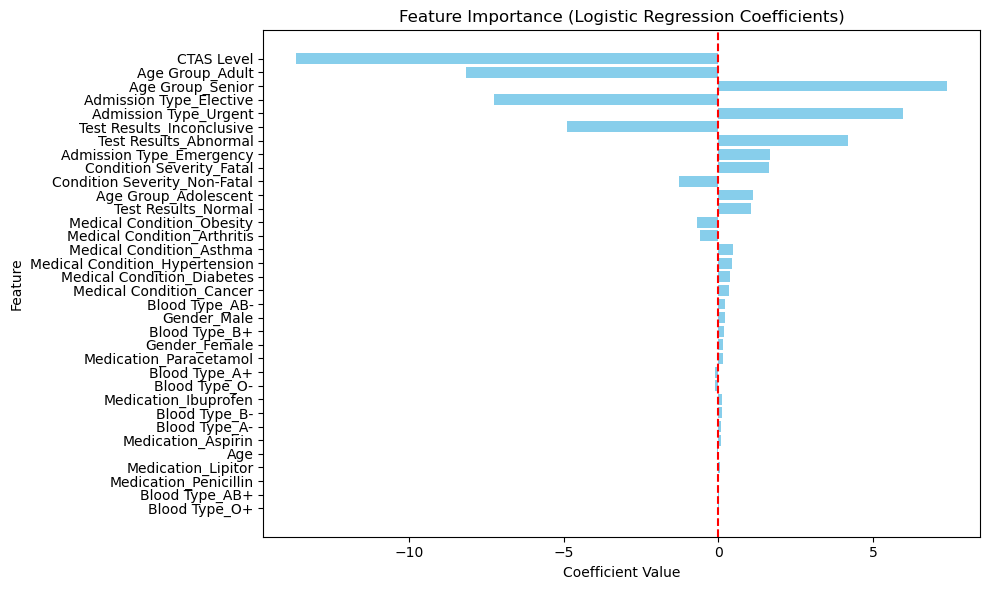

In [9]:
#with one hot encoding
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

original_df = pd.read_csv('synthetic_healthcare_data.csv')

df = original_df[['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Admission Type',
                 'Medication', 'Test Results', 'CTAS Level', 
                 'Condition Severity', 'Age Group', 'Churn']].copy()  # <-- Fix here

df['Churn'] = df['Churn'].astype(int) 

# Split data first to avoid leakage
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Create model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Train model
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance
# For logistic regression with one-hot encoding, we need to get feature names
feature_names = (numerical_cols.tolist() + 
                 list(model.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_cols)))

coefficients = model.named_steps['classifier'].coef_[0]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'], color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()